In [5]:
import xarray as xr
import numpy as np
from my_funs import est_trend
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from causalimpact import CausalImpact
dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"

In [6]:
lai_max = xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_annual_resample_max.nc"
).rename({"latitude":"lat","longitude":"lon"})
ndvi_max = xr.open_dataarray(dir+"data/processed_data/landsat/resampled/ndvi_annual_max.nc")
ndvi_max = ndvi_max.sel(time=slice("1985","2013")).rename({"latitude":"lat","longitude":"lon"})
ndvi_max = ndvi_max/1e4
nir = xr.open_dataarray(dir+"data/processed_data/landsat/resampled/nir.nc")
nir = nir.sel(time=slice("1985","2013"))
swi = xr.open_dataarray(dir+"data/processed_data/swi/swi.nc")
# lai_max["time"] = pd.date_range("1984","2014",freq = "A")
lai_max = lai_max.sel(time=slice("1985","2014"))  # 1984 has many nan values
arr = xr.open_dataarray(dir+"data/arr_id.nc")
percent_cover = (
    xr.open_dataarray(dir + "data/processed_data/percent_cover/percent_cover.nc")
)
percent_cover = percent_cover.loc["1985":"2013"]
percent_cover = percent_cover.round(2)
# If a class is 0 change it no nan to prevent false zeros in diff later
percent_cover = percent_cover.where(percent_cover != 0)
percent_cover["lat"] = lai_max["lat"]
percent_cover["lon"] =  lai_max["lon"]
percent_cover = percent_cover

In [ ]:
event_year = 2008
lc_diff = percent_cover.diff("time")
event = lc_diff.sel(time=event_year)
lcc = (event.where(event>0)).sum("band")
thresh = 0.5
lcc_dom = lcc.where(lcc>thresh)
changed_pixels = np.isfinite(lcc_dom)

# Index of pixels that have experienced significant LCC
I = np.where(changed_pixels==True)
print(len(I[0]))

28


In [21]:
winsize=3
win_size_half = int(np.floor(winsize / 2))
changed_pixels_roll = (changed_pixels.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)
lai_max_roll = (lai_max.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)

ndvi_max_roll = (ndvi_max.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)
swi_roll = (swi.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)


percent_cover_roll = (percent_cover.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)

lc_diff_roll = (lc_diff.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)

(29, 6)
(29, 12)


False

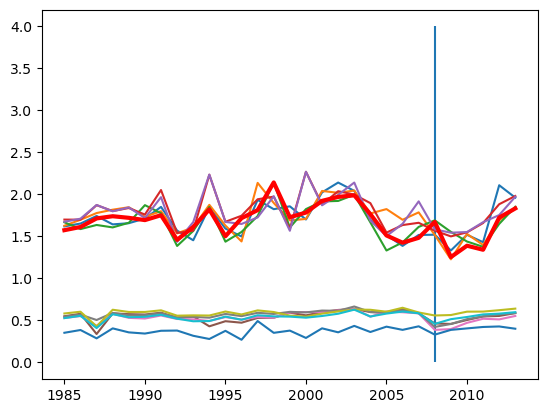

In [67]:
windows = np.empty((winsize,winsize))
windows[win_size_half,win_size_half] = np.nan
lc_surronding = np.argwhere(np.isfinite(windows))

# loop over pixels that have changed 
n = 5
idx = [I[0][n],I[1][n]]
# lc_diff[:,:,idx[0],idx[1]].to_pandas().plot(kind="bar",stacked=True,figsize=(18,10))
t=np.arange(1985,2014)
t_diff= np.arange(1986,2014)
event_index = np.where(t_diff==event_year)[0][0]

i = idx[0]
j = idx[1]

percent_cover_roll_tmp = percent_cover_roll[
     :, :, i, j, :, :]  # (30, 10, 3, 3)
lai_tmp = lai_max_roll[:,i,j,:,:]
lc_diff_roll_tmp = lc_diff_roll[:,:,idx[0],idx[1],:,:] #(28, 10, 3, 3)
lai_max_roll_tmp = lai_max_roll[:,idx[0],idx[1],:,:]
ndvi_max_roll_tmp = ndvi_max_roll[:,idx[0],idx[1],:,:]
swi_roll_tmp = swi_roll[:,idx[0],idx[1],:,:]


y = lai_tmp[:,win_size_half,win_size_half]

# loop over neighbor pixels
x_ndvi = []
x_lai = []
x_swi = []

for k in range(len(lc_surronding)):
    i_tmp = [lc_surronding[k][0],lc_surronding[k][1]] 

    m=5 # years to look bac for LCC 

    
    s1 = percent_cover_roll_tmp[event_index-(m-1):event_index+1,:,i_tmp[0],i_tmp[1]]
    s2 = np.isfinite(s1)
    # Check if the land covers for the past m years before the events are the same
    if (s2 == s2[0]).all():
        # If above is true then look for LCC
        d1 = lc_diff_roll_tmp[event_index-(m-1):event_index,:,i_tmp[0],i_tmp[1]]
        d1 = np.nan_to_num(d1,nan=0)

        # Check if LC has not changed over the m years before the events 
        if (np.abs(d1)<0.1).all():
            ndvi_tmp = ndvi_max_roll_tmp[:,i_tmp[0],i_tmp[1]]
            lai_tmp = lai_max_roll_tmp[:,i_tmp[0],i_tmp[1]]
            swi_tmp = swi_roll_tmp[:,i_tmp[0],i_tmp[1]]
            if (~np.isnan(ndvi_tmp).any()):
                x_ndvi.append(ndvi_tmp)
            if (~np.isnan(lai_tmp).any()):
                x_lai.append(lai_tmp)               
            
            if (~np.isnan(swi_tmp).any()):
                x_swi.append(swi_tmp) 
                
x_ndvi = np.array(x_ndvi).transpose()
x_lai = np.array(x_lai).transpose()
x_swi = np.array(x_swi).transpose()
# plt.plot(x_swi)
plt.plot(t,x_lai)
plt.plot(t,x_ndvi)
plt.plot(t,y,linewidth=3,color="red")
plt.vlines(2008,ymin=0,ymax=4)

yy = np.transpose(np.array(y,ndmin=2))
data_lai = np.concatenate([yy,x_lai],axis=1)
data_all = np.concatenate([yy,x_ndvi,x_lai],axis=1)

#np.isnan(data).any()

Data_all=pd.DataFrame(data=data_all,index=pd.date_range(start="1985",end="2014",freq="A"))
Data_lai=pd.DataFrame(data=data_lai,index=pd.date_range(start="1985",end="2014",freq="A"))
print(Data_lai.shape)
print(Data_all.shape)
np.isnan(yy).any()


Dealing with missing values

2023-03-31 07:27:38.618203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_fit_with_hmc/sample/InverseGamma/sample/PartitionedCall}}]]
2023-03-31 07:27:38.639833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_fit_with_hmc/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-03-31 07:27:38.658473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node InverseGamma_CONSTRUCTED_AT_fit_with_hmc/sample/Parti

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1.54               9.22
Prediction (s.d.)         1.64 (0.05)        9.81 (0.28)
95% CI                    [1.55, 1.73]       [9.28, 10.37]

Absolute effect (s.d.)    -0.1 (0.05)        -0.59 (0.28)
95% CI                    [-0.19, -0.01]     [-1.15, -0.06]

Relative effect (s.d.)    -6.04% (2.84%)     -6.04% (2.84%)
95% CI                    [-11.73%, -0.62%]  [-11.73%, -0.62%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.5%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1.54. By contrast, in the absence of an
intervention, we would have expected an average response of 1.64.
The 95% interval of this counterfactual prediction is [1.55, 1.73].
Subtracting this prediction from the observed respo

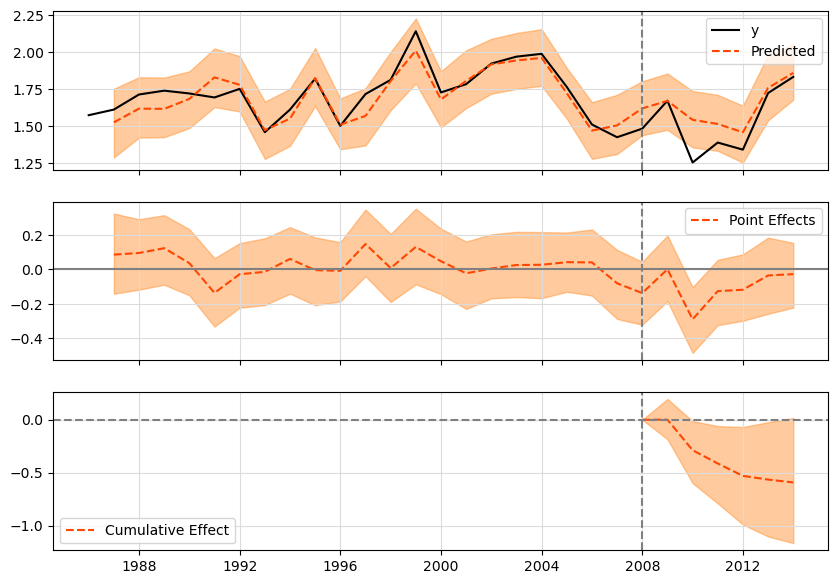

In [76]:
# pre_period = [0,16]
# post_period = [17,len(t)-1]
pre_period = ['19851231', '20071231']
post_period = ['20081231', '20131231']

ci = CausalImpact(Data_lai,
                  pre_period,
                  post_period,
                  model_args={
                      'fit_method': 'hmc',
                    #   'standardize': True,
                      'prior_level_sd':0.01                 })
# ci = CausalImpact(Data_lai, pre_period, post_period)
print(ci.summary())
print(ci.summary('report'))
ci.plot()

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/WillianFuks/tfcausalimpact/master/tests/fixtures/arma_data.csv')[['y', 'X']]
data.iloc[70:, 0] += 5

pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

(29, 2108)

2023-03-30 19:49:08.717710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-03-30 19:49:08.717809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-03-30 19:49:08.727086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-03-30 19:49:08.727202: I tens

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2.2                26.44
Prediction (s.d.)         -14.05 (32.78)     -168.62 (393.4)
95% CI                    [-84.65, 43.86]    [-1015.79, 526.31]

Absolute effect (s.d.)    16.25 (32.78)      195.05 (393.4)
95% CI                    [-41.66, 86.85]    [-499.87, 1042.22]

Relative effect (s.d.)    -115.68% (233.31%) -115.68% (233.31%)
95% CI                    [-618.1%, 296.45%] [-618.1%, 296.45%]

Posterior tail-area probability p: 0.27
Posterior prob. of a causal effect: 72.73%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2.2. By contrast, in the absence of an
intervention, we would have expected an average response of -14.05.
The 95% interval of this counterfactual prediction is [-84.65, 43.86].
Subtracting this predicti

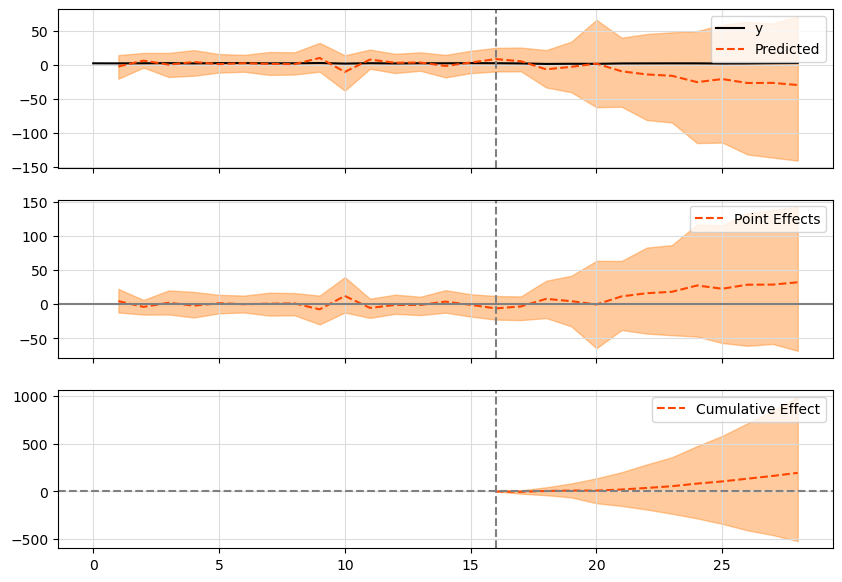

In [39]:
from causalimpact.misc import standardize
import tensorflow_probability as tfp

Data = pd.DataFrame(data)
normed_data, _ = standardize(Data.astype(np.float32))

obs_data = normed_data.iloc[:16, 0]
linear_level = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)
linear_reg = tfp.sts.LinearRegression(design_matrix=normed_data.iloc[:, 1:].values.reshape(-1, normed_data.shape[1] -1))
model = tfp.sts.Sum([linear_level, linear_reg], observed_time_series=obs_data)
ci = CausalImpact(data, pre_period, post_period, model=model)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()